In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import scale
from sklearn.metrics import classification_report


In [34]:
data = pd.read_csv('data_SARS-CoV-2_TestMetadata_edited.csv')
data.head() # print the first 5 rows of the data

,record_date,virus_name,accession_id,type,lineage,passage_details_history,collection_date,location,host,additional_location_info,...,originating_lab_address,sample_id_given_by_sample_provider,submitting_lab,submitting_lab_address,sample_id_given_by_submitting_lab,authors,submitter,submission_date,submitter_address,variants
0,3/19/2020,NaN,EPI_ISL_408976,betacoronavirus,NaN,Vero P1,1/22/2020,Oceania / Australia / New South Wales / Sydney,Human,NaN,...,NSW Health Pathology - Institute of Clinical P...,NaN,NSW Health Pathology - Institute of Clinical P...,"Westmead Hospital, Hawkesbury Road, Westmead N...",NaN,"Rockett R, Sadsad R, Eden J-S, Carter I, Rahma...",John-Sebastian Eden,2/11/2020,"Westmead Institute for Medical Research, 176 H...",NaN
1,3/19/2020,NaN,EPI_ISL_408977,betacoronavirus,NaN,Original,1/25/2020,Oceania / Australia / New South Wales / Sydney,Human,NaN,...,"Level 4 Campus Centre, Prince of Wales Hospita...",NaN,NSW Health Pathology - Institute of Clinical P...,"Westmead Hospital, Hawkesbury Road, Westmead N...",NaN,"Eden J-S, Carter I, Rahman H, Rawlinson W, Hol...",John-Sebastian Eden,2/11/2020,"Westmead Institute for Medical Research, 176 H...",NaN
2,3/19/2020,NaN,EPI_ISL_410486,betacoronavirus,NaN,Original,2/8/2020,Europe / France / Rhone-Alpes / Contamines,Human,NaN,...,"103 Grande Rue de la Croix-Rousse, 69317 cedex...",NaN,CNR Virus des Infections Respiratoires - Franc...,"103 Grande Rue de la Croix-Rousse, 69317 cedex...",NaN,"Bal, Antonin; Destras, Gregory; Gaymard, Alexa...",Laurence Josset,2/14/2020,"103 Grande Rue de la Croix-Rousse, 69317 cedex...",NaN
3,3/19/2020,NaN,EPI_ISL_414690,betacoronavirus,NaN,Original,2/25/2020,Asia / China / Guangdong / Guangzhou,Human,NaN,...,"Institute of Respiratory Health, the First Af...",NaN,The First Affiliated Hospital of Guangzhou Med...,"195 Dongfeng Xi Road, Yuexiu District, Guangzh...",NaN,Zhao et al,Jingkai Ji,3/16/2020,"Building 11, Beishan Industrial Zone, Yantian ...",NaN
4,3/18/2020,NaN,EPI_ISL_415435,betacoronavirus,NaN,Original,3/6/2020,Europe / United Kingdom / Wales,Human,NaN,...,"University Hospital of Wales, Heath Park, Card...",NaN,Public Health Wales Microbiology Cardiff,"University Hospital of Wales, Heath Park, Card...",NaN,"Catherine Moore, Joanne Watkins, Sally Corden,...",Catherine Moore,3/17/2020,"University Hospital of Wales, Heath Park, Card...",NaN


In [35]:
#important features
Data = data.loc[ : , ['location','gender','age','status'] ]
Data.head()

,location,gender,age,status
0,Oceania / Australia / New South Wales / Sydney,male,53,Recovered
1,Oceania / Australia / New South Wales / Sydney,Female,21,Recovered
2,Europe / France / Rhone-Alpes / Contamines,Female,56,NaN
3,Asia / China / Guangdong / Guangzhou,Male,79,NaN
4,Europe / United Kingdom / Wales,Female,54,NaN


In [36]:
#organizing the location based on the continent and country (For USA: continent,country, and state )
Location = Data.location.str.split('/')
listToStr_location = list()
for i in range(len(Location)):  
    if Location[i][1:2][0]!=' USA ':
        Location[i] = Location[i][0:2]
        listToStr_location. append(' '.join([str(elem) for elem in Location[i]]))
    else:
        Location[i] = Location[i][0:3]
        listToStr_location. append(' '.join([str(elem) for elem in Location[i]]))
listToStr_location

['Oceania   Australia ',
 'Oceania   Australia ',
 'Europe   France ',
 'Asia   China ',
 'Europe   United Kingdom ',
 'Europe   Netherlands ',
 'Europe   Netherlands ',
 'Europe   Netherlands ',
 'Europe   Netherlands ',
 'Europe   Netherlands ',
 'Europe   Netherlands',
 'Europe   Netherlands',
 'Europe   Netherlands',
 'Europe   United Kingdom ',
 'Europe   United Kingdom ',
 'North America   USA   Utah',
 'North America   USA   Utah',
 'North America   USA   Utah',
 'North America   USA   Utah',
 'North America   USA   Utah',
 'North America   Canada ',
 'North America   Canada ',
 'North America   Canada ',
 'North America   Canada ',
 'North America   Canada ',
 'North America   Canada ',
 'North America   Canada ',
 'North America   Canada ',
 'North America   Canada ',
 'North America   Canada ',
 'North America   Canada ',
 'North America   Canada ',
 'North America   Canada ',
 'North America   Canada ',
 'North America   USA   Washington',
 'North America   USA   Washington'

In [37]:
Data.location =listToStr_location
Data.groupby('location')

In [38]:
#getting rid of NaN data
Data.dropna(subset = ['status'], inplace=True)

In [39]:
#getting rid of NaN data
Data.drop(Data.loc[Data['status']=='unknown'].index, inplace=True)

In [40]:
#labeling the data
Data.replace(['female','Female'],value= [1,1], inplace=True)
Data.replace(['male','Male'],value= [0,0], inplace=True)
Data.replace(['Deceased'],value= [0], inplace=True)
Data.status[Data['status'] != 0]=1
Data.head()

,location,gender,age,status
0,Oceania Australia,0,53,1
1,Oceania Australia,1,21,1
52,Asia Georgia,1,2.5,1
53,Asia Georgia,0,5,1
54,Asia Georgia,0,33.5,1


In [41]:
#Finding unknown data
Data.loc[Data['gender']=='unknown']

,location,gender,age,status
222,Asia Japan,unknown,unknown,1


In [42]:
#finding the countries containing unknowns
Unknown_Data = Data[Data.location.str.contains(pat = 'Japan')]
Unknown_Data

,location,gender,age,status
178,Asia Japan,1,84,0
182,Asia Japan,0,48,1
186,Asia Japan,1,45,1
187,Asia Japan,0,65,1
188,Asia Japan,0,35,1
216,Asia Japan,0,75,1
217,Asia Japan,1,75,1
222,Asia Japan,unknown,unknown,1


In [43]:
#substituting age and gender unknown data with the average of the age and most common gender in that city 
#df.mean(axis = 1, skipna = True) 
unknown_gender = np.bincount(Unknown_Data.gender.loc[Data['gender']!='unknown']).argmax()
unknown_age = (Unknown_Data.age.loc[Data['age']!='unknown']).astype(int)
unknown_age = unknown_age.mean()
print('unknown_gender = ',unknown_gender)
print('unknown_age = ',unknown_age)

unknown_gender =  0
unknown_age =  61.0


In [44]:
#imputing the missing data
Data.gender.replace(['unknown'],value= [unknown_gender], inplace=True)
Data.age.replace(['unknown'],value= [unknown_age], inplace=True)
Data[Data.location.str.contains(pat = 'Japan')]

,location,gender,age,status
178,Asia Japan,1,84,0
182,Asia Japan,0,48,1
186,Asia Japan,1,45,1
187,Asia Japan,0,65,1
188,Asia Japan,0,35,1
216,Asia Japan,0,75,1
217,Asia Japan,1,75,1
222,Asia Japan,0,61,1


In [45]:
#using dummies instead of location data for ML input
Data_model = pd.concat([pd.get_dummies(Data[['location']]), Data[['gender','age','status']]], axis=1)
Data_model.head()

,location_Africa Egypt,location_Africa Nigeria,location_Asia Bangladesh,location_Asia China,location_Asia Georgia,location_Asia Hong Kong,location_Asia India,location_Asia Iran,location_Asia Israel,location_Asia Japan,...,location_Oceania Australia,location_Oceania Guam,location_Oceania New Zealand,location_South America Brazil,location_South America Colombia,location_South America Ecuador,location_South America Uruguay,gender,age,status
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,53,1
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,21,1
52,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,2.5,1
53,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,1
54,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,33.5,1


In [46]:
#checking the balance in the data
Data_model['status'].value_counts()

1    171
0     32
Name: status, dtype: int64

In [47]:
#Separating target (label) data
X = Data_model.drop('status',axis=1).astype(float)
y = Data_model.status
y=y.astype(int)
y

0      1
1      1
52     1
53     1
54     1
55     1
56     1
57     1
58     1
59     1
60     1
61     1
62     1
63     1
64     1
65     1
66     1
67     1
68     1
69     1
70     1
71     1
72     1
73     1
74     1
75     1
76     1
77     1
78     1
79     1
      ..
223    1
224    1
225    1
226    1
227    1
228    1
229    1
230    1
231    1
232    1
233    0
234    0
235    0
236    0
237    0
238    0
239    0
240    1
241    1
242    1
243    1
244    1
245    1
246    0
247    1
248    1
249    1
250    1
251    1
252    1
Name: status, Length: 203, dtype: int32

In [48]:
#splitting features and the label: 20% test data and 80% assigned to training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)


In [49]:
#balancing the data
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=12, ratio = 1)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
y_majority = y_train_res[y_train_res==1]
y_minority = y_train_res[y_train_res==0]
print(y_majority.size)
print(y_minority.size)

136
136


In [50]:
#Scaling the data to standarize them
#Here caling reduced the iteration number from 200 to 50
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train_res)
X_train = sc.transform(X_train_res)
X_test = sc.transform(X_test)

In [51]:
#fitting the model and get the conversion probabilities. 
#predit_proba() function of our model assigns probability for each row:
logmodel = LogisticRegression(solver='lbfgs', penalty='l2',C= 1, max_iter=200, n_jobs=1, tol=0.0001)
logmodel.fit(X_train_res,y_train_res)
y_hat = logmodel.predict(X_test)
lr_probs = logmodel.predict_proba(X_test)
#Return the mean accuracy on the given test data and taraining data to see if we have overfitting.score clculates R^2
print('R^2 _train=',logmodel.score(X_train_res, y_train_res))
print('R^2 _test=',logmodel.score(X_test, y_test))
#print(confusion_matrix(y_test,y_hat))
#reporting the results of classification
print(classification_report(y_test,y_hat))

R^2 _train= 0.9411764705882353
R^2 _test= 0.9512195121951219
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         6
           1       0.95      1.00      0.97        35

    accuracy                           0.95        41
   macro avg       0.97      0.83      0.89        41
weighted avg       0.95      0.95      0.95        41



In [52]:
from sklearn.metrics import precision_recall_curve
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_hat)

In [53]:
from sklearn.metrics import f1_score
# calculate F1 score
f1 = f1_score(y_test, y_hat)
print('f1 score =', f1)

f1 score = 0.9722222222222222


In [54]:
#Area Under ROC Curve (AUROC) metric
from sklearn.metrics import roc_auc_score
lr_probs = logmodel.predict_proba(X_test)
# Keep only the positive class
#lr_probs = [p[1] for p in lr_probs]
print( 'roc_auc =', roc_auc_score(y_test, lr_probs[:,1]) )

roc_auc = 1.0


No Skill: ROC AUC=0.500
Logistic: ROC AUC=1.000


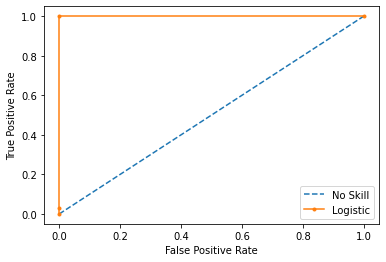

In [55]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
lr_probs = logmodel.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Logistic: f1=0.972 auc=1.000


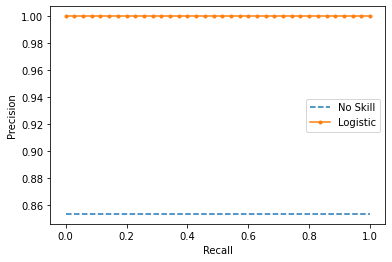

In [56]:
from sklearn.metrics import auc
lr_probs = logmodel.predict_proba(X_test)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs[:,1])
lr_f1, lr_auc = f1_score(y_test, y_hat), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()


Logistic: f1=0.972 auc=1.000


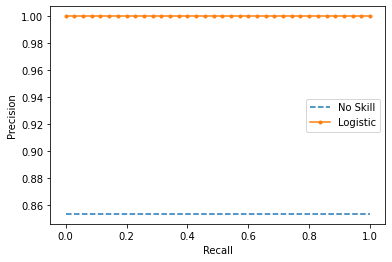

In [25]:
# precision-recall curve and f1
from sklearn.metrics import precision_recall_curve

lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs[:,1])
lr_f1, lr_auc = f1_score(y_test, y_hat), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [26]:
#from sklearn.svm import SVC
#from sklearn.model_selection import train_test_split
#from sklearn.model_selection import GridSearchCV
#from sklearn.metrics import classification_report,confusion_matrix
#from sklearn.preprocessing import StandardScaler
#from sklearn.metrics import accuracy_score
#model = SVC(gamma='auto',max_iter=400)
#model.fit(X_train_res,y_train_res)
#predictions = model.predict(X_test)
#print(confusion_matrix(y_test,predictions))
#print(model.score(X_train_res, y_train_res))
#print( 'Test_accuracy = ', accuracy_score(y_test, predictions) )